In [1]:
# ====== Packages =======
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh


In [2]:
class Net(nn.Module):
    def __init__(self, nuerons_num: list):
        super().__init__()
        self.fc1 = nn.Linear(nuerons_num[0], nuerons_num[1])
        self.fc2 = nn.Linear(nuerons_num[1], nuerons_num[2])
        self.fc3 = nn.Linear(nuerons_num[2], nuerons_num[3])
    
    def forward(self, net_input):
        z = self.fc1(net_input)
        a = F.relu(z)
        z = self.fc2(a)
        a = F.relu(z)
        z = self.fc3(a)
        
        return F.sigmoid(z)



In [13]:
dataset2 = pd.read_pickle('data_for_tree2.pkl')
X_train_raw, y_train_raw, X_test, y_test = mh.data_split(dataset2 ,n_splits=1, test_size=0.4, train_size=0.6)
X_train, y_train = mh.up_down_sampling(X_train_raw, y_train_raw, ratio=1, up=True)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test , n_splits=1, test_size=0.5, train_size=0.5)


X_train, y_train, X_test, y_test, X_val, y_val = (torch.from_numpy(X_train.values), torch.from_numpy(y_train.values), 
                                                 torch.from_numpy(X_test.values), torch.from_numpy(y_test.values), 
                                                 torch.from_numpy(X_val.values), torch.from_numpy(y_val.values))


In [14]:
y_train.value_counts()

AttributeError: 'Tensor' object has no attribute 'value_counts'

In [8]:
dataset2

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,symp_num,test_indication_0,test_indication_1,test_indication_2,corona_result
0,18,0,0,0,0,0,0,1,0,0,0
1,18,1,0,0,0,0,1,1,0,0,0
2,18,0,1,0,0,0,1,1,0,0,0
3,18,1,0,0,0,0,1,1,0,0,0
4,18,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
274697,11,0,0,0,0,0,0,1,0,0,0
274698,11,0,0,0,0,0,0,1,0,0,0
274699,11,0,0,0,0,0,0,1,0,0,0
274700,11,0,0,0,0,0,0,0,1,0,1


In [7]:
X_train.size()

torch.Size([312010, 10])

### Split the data to batches:

In [16]:
batch_size = 64
y_train = torch.reshape(y_train, (y_train.size()[0], 1))
train_set = torch.cat((X_train, y_train), dim=1)

# Shuffle the data before spliting so we wont get batches of all ones and all zeros
train_set = train_set[torch.randperm(train_set.size()[0]),:].float()
batches = torch.split(train_set, batch_size)


In [21]:
batches[600][:,-1]

tensor([1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])

In [22]:
net = Net([10, 17, 19,1])
loss_func = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum=0.9)
epoches = 2
 

for epoch in range(epoches):
    for i, batch in enumerate(batches):
        # get inputs and targets
        inputs, targets = batch[:,:-1], batch[:, -1]
        targets = torch.reshape(targets, (inputs.size()[0], 1))
        # zero the parameters gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 10 == 0: # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, loss))
        

print('Finished Training')

/home/nirlalum/.local/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,     1] loss: 0.737
[1,    11] loss: 0.685
[1,    21] loss: 0.568
[1,    31] loss: 0.605
[1,    41] loss: 0.632
[1,    51] loss: 0.711
[1,    61] loss: 0.666
[1,    71] loss: 0.669
[1,    81] loss: 0.654
[1,    91] loss: 0.552
[1,   101] loss: 0.537
[1,   111] loss: 0.711
[1,   121] loss: 0.490
[1,   131] loss: 0.577
[1,   141] loss: 0.875
[1,   151] loss: 0.756
[1,   161] loss: 0.655
[1,   171] loss: 0.608
[1,   181] loss: 0.680
[1,   191] loss: 0.697
[1,   201] loss: 0.697
[1,   211] loss: 0.691
[1,   221] loss: 0.707
[1,   231] loss: 0.691
[1,   241] loss: 0.693
[1,   251] loss: 0.693
[1,   261] loss: 0.694
[1,   271] loss: 0.697
[1,   281] loss: 0.693
[1,   291] loss: 0.695
[1,   301] loss: 0.690
[1,   311] loss: 0.694
[1,   321] loss: 0.696
[1,   331] loss: 0.701
[1,   341] loss: 0.694
[1,   351] loss: 0.690
[1,   361] loss: 0.693
[1,   371] loss: 0.692
[1,   381] loss: 0.693
[1,   391] loss: 0.694
[1,   401] loss: 0.694
[1,   411] loss: 0.686
[1,   421] loss: 0.694
[1,   431] 

+--------------+----------------------+
|    Metric    |        Score         |
+--------------+----------------------+
|   accuracy   | 0.053494721514379326 |
|    recall    |         1.0          |
|  presicion   | 0.053494721514379326 |
|   f1 score   | 0.10155669586551254  |
| f_beta score | 0.22032805565551158  |
+--------------+----------------------+


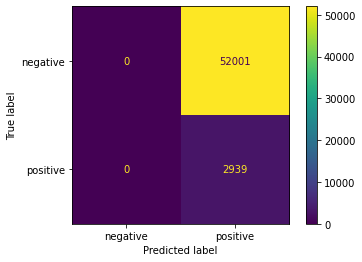

In [23]:
y_pred = 1*(net.forward(X_test.float())>0.5)
mh.model_evaluation(y_test.detach().numpy(), y_pred.detach().numpy())